In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import seaborn as sns
import pandas as pd

df = pd.read_stata("C:/Users/Patrick/Dropbox/ds/analysis_demo/azella_rd.dta")

In [2]:
#Proficiency
df['Tested_Proficient'] = np.where(df['not_proficient'] == 0, "Proficient", "Approaching Proficient") 
df['Tested_Proficient_pct'] = np.where(df['not_proficient'] == 0, 0, 100) 

#Demographics
df['Hispanic_pct'] = np.where(df['ethnicity'] == "H", 100, 0) 
df['Male_pct'] = np.where(df['gender'] == "M", 100, 0)
df['Subsidized_Lunch_pct'] = np.where(df['freelunch'] == 1, 100,0)

#Academic performance (before program)
df['Reading_8th_Grade_Score'] = df['aims_read_8'].astype(float).round(2)
df['Math_8th_Grade_Score'] = df['aims_math_8'].astype(float).round(2)

#Program enrollment rates
df['Enrolled_9th_Grade_pct'] = np.where(df['ell']==1,100,0)
df['Enrolled_10th_Grade_pct'] = np.where(df['ell_10']==1,100,0)
df['Enrolled_9th_Grade'] = np.where(df['ell']==1,"Enrolled in Program", "Not Enrolled in Program")

#Academic Performance after Program

df['Reading_10th_Grade_Score'] = df['aims_read_10']
df['Math_10th_Grade_Score'] = df['aims_math_10']
df['Graduated_pct'] = np.where(df['ever_graduate']==1,100,0)



In [3]:
summary_variables = ["Hispanic_pct", "Male_pct", "Subsidized_Lunch_pct", "Reading_8th_Grade_Score", "Math_8th_Grade_Score", "Tested_Proficient_pct"]
for variables in summary_variables:
    print('\033[1m'+variables+ '\033[0m')
    print(np.round(df.groupby(['Enrolled_9th_Grade'])[variables].describe(percentiles=[])[['count','mean', 'std']],2).T)

Hispanic_pct
Enrolled_9th_Grade  Enrolled in Program  Not Enrolled in Program
count                           7629.00                  9608.00
mean                              74.71                    80.56
std                               43.47                    39.58
Male_pct
Enrolled_9th_Grade  Enrolled in Program  Not Enrolled in Program
count                           7629.00                  9608.00
mean                              56.63                    52.10
std                               49.56                    49.96
Subsidized_Lunch_pct
Enrolled_9th_Grade  Enrolled in Program  Not Enrolled in Program
count                           7629.00                  9608.00
mean                              76.65                    62.83
std                               42.31                    48.33
Reading_8th_Grade_Score
Enrolled_9th_Grade  Enrolled in Program  Not Enrolled in Program
count                           6752.00                  8267.00
mean                   

In [4]:
summary_variables = ["Reading_10th_Grade_Score", "Math_10th_Grade_Score", "Graduated_pct"]
for variables in summary_variables:
    print('\033[1m'+variables+ '\033[0m')
    print(np.round(df.groupby(['Enrolled_9th_Grade'])[variables].describe(percentiles=[])[['count','mean', 'std']],2).T)

Reading_10th_Grade_Score
Enrolled_9th_Grade  Enrolled in Program  Not Enrolled in Program
count                           6047.00                  8041.00
mean                              -1.19                    -0.55
std                                0.64                     0.79
Math_10th_Grade_Score
Enrolled_9th_Grade  Enrolled in Program  Not Enrolled in Program
count                           5947.00                  7992.00
mean                              -0.95                    -0.43
std                                0.64                     0.80
Graduated_pct
Enrolled_9th_Grade  Enrolled in Program  Not Enrolled in Program
count                           7629.00                  9608.00
mean                              49.85                    63.76
std                               50.00                    48.07


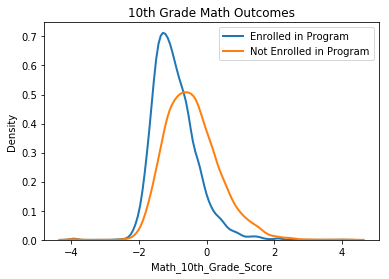

In [5]:
import matplotlib.pyplot as plt 
import seaborn as sns

ell_df = df[df['ell'] == 1]
not_ell_df = df[df['ell'] == 0]

sns.distplot(ell_df["Math_10th_Grade_Score"], hist = False, kde = True,
                 kde_kws = {'linewidth': 2},
                 label = "Enrolled in Program")

sns.distplot(not_ell_df["Math_10th_Grade_Score"], hist = False, kde = True,
                 kde_kws = {'linewidth': 2},
                 label = "Not Enrolled in Program")

plt.ylabel('Density')
plt.title('10th Grade Math Outcomes')
plt.rcParams['figure.figsize'] = [8, 5]


In [6]:
import xgboost as xgb
from xgboost import plot_tree
from sklearn.metrics import mean_squared_error

In [7]:
y = df[["Graduated_pct"]]
X = df[['Hispanic_pct', 'Male_pct', 'Subsidized_Lunch_pct', 'Enrolled_9th_Grade_pct', "Reading_8th_Grade_Score", "Math_8th_Grade_Score"]]

data_dmatrix = xgb.DMatrix(data=X, label=y)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)


In [8]:
params = {"objective":"reg:linear",'colsample_bytree': .7,'learning_rate': 0.5,
                'max_depth': 3, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=1)

In [12]:
cv_results.head()
print((cv_results["test-rmse-mean"]).tail(1))

7    45.610008
Name: test-rmse-mean, dtype: float64


In [13]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

In [10]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

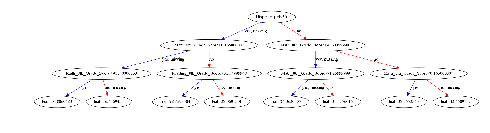

In [11]:
from xgboost import plot_tree
xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [8, 4]
plt.show()

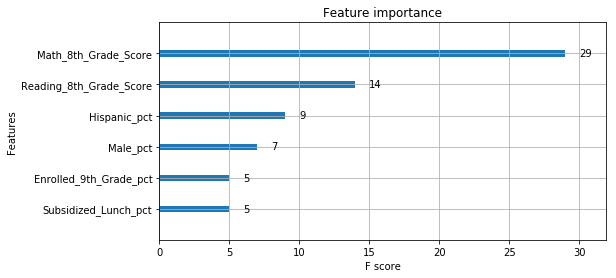

In [12]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [10, 5]
plt.show()

In [13]:
bins = np.arange(-50,55,3)
df['binned'] = np.searchsorted(bins, df['minxscore_c'].values)
df['bin'] = df['binned']*3 -50

df_analysis = df[['ell','ell_10','binned','bin','minxscore_c', 'minxscore2_c', 'Tested_Proficient_pct', 'Reading_10th_Grade_Score', 'Math_10th_Grade_Score', 'Graduated_pct', 'Hispanic_pct', 'Male_pct', 'Subsidized_Lunch_pct' ]]
df_analysis = df_analysis.sort_values('minxscore_c')

df_analysis['Proficiency Score'] = df_analysis['bin']
df_analysis['Enrolled in ELL Program (9th Grade)'] = df_analysis['ell']
df_analysis['Enrolled in ELL Program (10th Grade)'] = df_analysis['ell_10']
df_analysis['Proficiency Score'] = df_analysis['bin']
df_analysis['Graduated'] = df_analysis['Graduated_pct']/100

df_analysis['minxscore_c_int'] = df_analysis['minxscore_c']*df_analysis['Tested_Proficient_pct']

In [14]:
df_not_proficient = df_analysis[df_analysis['minxscore_c'] <= -2] [df_analysis['minxscore_c'] > -30]
df_proficient = df_analysis[df_analysis['minxscore_c'] > -2] [df_analysis['minxscore_c'] <  30]

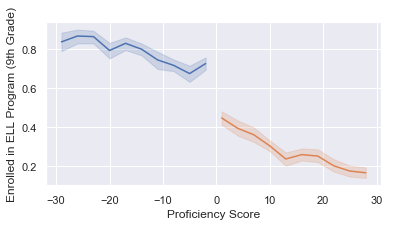

In [23]:
sns.set(style="darkgrid")

# Plot the responses for different events and regions
ax1 = sns.lineplot(x="Proficiency Score", y="Enrolled in ELL Program (9th Grade)", data= df_not_proficient)
ax2 = sns.lineplot(x="Proficiency Score", y="Enrolled in ELL Program (9th Grade)", data=df_proficient)

plt.rcParams['figure.figsize'] = [6, 3]

ax = sns.boxplot(x="bin", y="ell", data=df3)

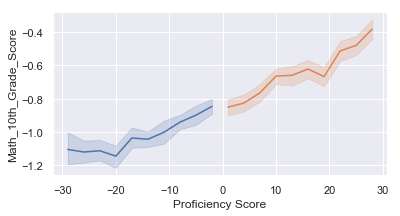

In [16]:
sns.set(style="darkgrid")

# Plot the responses for different events and regions
ax1 = sns.lineplot(x="Proficiency Score", y="Math_10th_Grade_Score", data= df_not_proficient)
ax2 = sns.lineplot(x="Proficiency Score", y="Math_10th_Grade_Score", data=df_proficient)

plt.rcParams['figure.figsize'] = [6, 3]

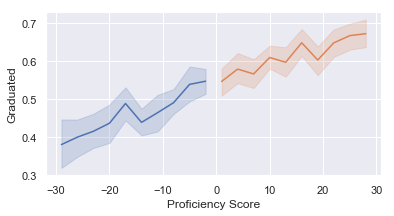

In [17]:
sns.set(style="darkgrid")

# Plot the responses for different events and regions
ax1 = sns.lineplot(x="Proficiency Score", y="Graduated", data= df_not_proficient)
ax2 = sns.lineplot(x="Proficiency Score", y="Graduated", data=df_proficient)

plt.rcParams['figure.figsize'] = [6, 3]

In [18]:
df['fiscalyear'] = df['fiscalyear'].astype(int)

In [19]:
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col

df_reg = pd.get_dummies(df, prefix='FY', columns=['fiscalyear'])

In [20]:
import statsmodels.api as sm
mod = smf.ols('Math_10th_Grade_Score ~ Tested_Proficient_pct + minxscore_c + minxscore2_c + int1 + Hispanic_pct + Male_pct + \
               Subsidized_Lunch_pct + FY_2009 + FY_2010 + FY_2011', data = df_reg)
res = mod.fit()
info_dict={'R-squared' : lambda x: f"{x.rsquared:.2f}"}

dfoutput = summary_col([res],stars=True, info_dict = info_dict, model_names=['Linear'])
dfoutput.tables[0] = dfoutput.tables[0]
print(dfoutput)




                        Linear  
--------------------------------
Intercept             -0.4515***
                      (0.0219)  
Tested_Proficient_pct -0.0004** 
                      (0.0002)  
minxscore_c           0.0071*** 
                      (0.0008)  
minxscore2_c          -0.0000***
                      (0.0000)  
int1                  0.0136*** 
                      (0.0012)  
Hispanic_pct          -0.0029***
                      (0.0002)  
Male_pct              -0.0000   
                      (0.0001)  
Subsidized_Lunch_pct  -0.0003** 
                      (0.0001)  
FY_2009               -0.0464***
                      (0.0145)  
FY_2010               -0.3772***
                      (0.0158)  
FY_2011               -0.4123***
                      (0.0166)  
R-squared             0.33      
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


In [21]:
import statsmodels.api as sm
mod = smf.ols('ever_graduate ~ Tested_Proficient_pct + minxscore_c + minxscore2_c + int1 + Hispanic_pct + Male_pct + \
               Subsidized_Lunch_pct + FY_2009 + FY_2010 + FY_2011', data = df_reg)
res = mod.fit()
info_dict={'R-squared' : lambda x: f"{x.rsquared:.2f}"}

dfoutput = summary_col([res],stars=True, info_dict = info_dict, model_names=['Linear'])
dfoutput.tables[0] = dfoutput.tables[0]
print(dfoutput)




                        Linear  
--------------------------------
Intercept             0.4637*** 
                      (0.0140)  
Tested_Proficient_pct -0.0004***
                      (0.0001)  
minxscore_c           0.0021*** 
                      (0.0005)  
minxscore2_c          -0.0000** 
                      (0.0000)  
int1                  0.0020**  
                      (0.0008)  
Hispanic_pct          0.0027*** 
                      (0.0001)  
Male_pct              -0.0008***
                      (0.0001)  
Subsidized_Lunch_pct  -0.0003***
                      (0.0001)  
FY_2009               -0.0435***
                      (0.0096)  
FY_2010               -0.1023***
                      (0.0105)  
FY_2011               -0.0642***
                      (0.0112)  
R-squared             0.10      
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01
